In [2]:
# Shanghai Pre Training Pipeline

# Import required libraries
import os
import requests
import zipfile
import tarfile
import torch
import torch.nn.functional as F
import glob
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
from rasterio.features import rasterize
import rasterio.features as rfeat
import geopandas as gpd
from shapely.geometry import box, mapping, Polygon
import pandas as pd
import matplotlib.pyplot as plt
import timm
from torchvision import transforms
import torchvision.transforms as T
from PIL import Image
import warnings
from tqdm import tqdm
import csv
import math
import time
from pyproj import Transformer
import re
from dinov2.models.vision_transformer import vit_base

In [27]:
# Download Sample Spacenet_4 Data  
# This downloads images + building footprints from SpaceNet Shanghai.

# Create folders
os.makedirs("../data/spacenet/AOI_4_Shanghai", exist_ok=True)

url = "https://spacenet-dataset.s3.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_4_Shanghai.tar.gz"
out_path = "../data/spacenet/AOI_4_Shanghai.tar.gz"

# Download file
if not os.path.exists(out_path):
    print("Downloadinzg AOI_4_Shanghai...")
    r = requests.get(url, stream=True)
    with open(out_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
else:
    print("File already exists:", out_path)

# Extract TAR.GZ
print("Extracting...")
with tarfile.open(out_path, "r:gz") as tar:
    tar.extractall("../data/spacenet/AOI_4_Shanghai")

print("Shanghai AOI extraction complete.")

Extracting...


/var/folders/n1/byh8k_mx5mb24hn1k_w2vjr00000gn/T/ipykernel_1132/4044288494.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("../data/spacenet/AOI_4_Shanghai")


Shanghai AOI extraction complete.


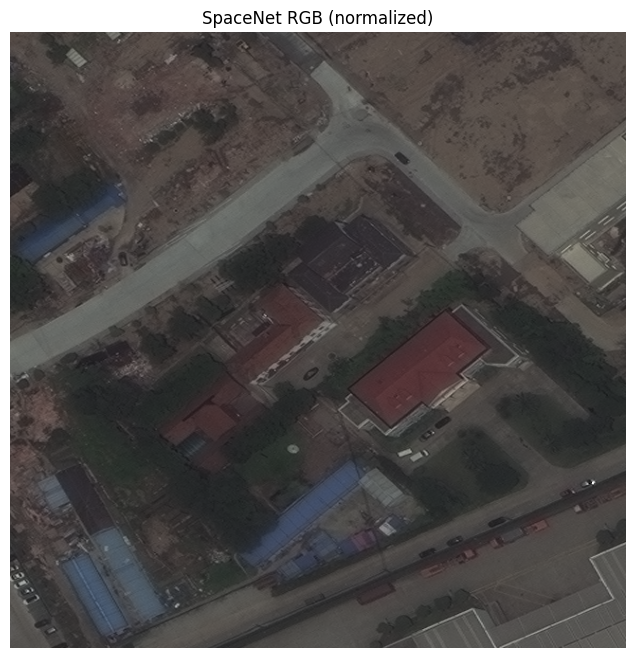

In [32]:
# show an image

img_path = "../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img305.tif"  # example

with rasterio.open(img_path) as src:
    img = src.read()   # shape: (3, H, W)

# Normalize for visualization
norm = img.astype(float)
for c in range(3):
    norm[c] = (norm[c] - norm[c].min()) / (norm[c].max() - norm[c].min())

# Reorder to HWC
norm = np.transpose(norm, (1, 2, 0))

plt.figure(figsize=(8,8))
plt.imshow(norm)
plt.title("SpaceNet RGB (normalized)")
plt.axis("off")
plt.show()

In [33]:
# show details for an image

img_path = "../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img305.tif"  # example

with rasterio.open(img_path) as src:
    print("Band count:", src.count)
    print("Shape:", src.read().shape)

Band count: 3
Shape: (3, 650, 650)


In [40]:
# show building footprints head

geojson_path = "../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/geojson/buildings"

if os.path.exists(geojson_path):
    print("\nGeoJSON building samples:")
    print(sorted(os.listdir(geojson_path))[:20])


GeoJSON building samples:
['buildings_AOI_4_Shanghai_img1001.geojson', 'buildings_AOI_4_Shanghai_img1002.geojson', 'buildings_AOI_4_Shanghai_img1003.geojson', 'buildings_AOI_4_Shanghai_img1005.geojson', 'buildings_AOI_4_Shanghai_img1007.geojson', 'buildings_AOI_4_Shanghai_img1008.geojson', 'buildings_AOI_4_Shanghai_img1009.geojson', 'buildings_AOI_4_Shanghai_img1010.geojson', 'buildings_AOI_4_Shanghai_img1012.geojson', 'buildings_AOI_4_Shanghai_img1013.geojson', 'buildings_AOI_4_Shanghai_img1014.geojson', 'buildings_AOI_4_Shanghai_img1015.geojson', 'buildings_AOI_4_Shanghai_img1016.geojson', 'buildings_AOI_4_Shanghai_img1017.geojson', 'buildings_AOI_4_Shanghai_img1018.geojson', 'buildings_AOI_4_Shanghai_img1020.geojson', 'buildings_AOI_4_Shanghai_img1022.geojson', 'buildings_AOI_4_Shanghai_img1023.geojson', 'buildings_AOI_4_Shanghai_img1024.geojson', 'buildings_AOI_4_Shanghai_img1025.geojson']


In [1]:
# show image head

root = "../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen"

for name in sorted(os.listdir(root))[:20]:   
    print(name)

.ipynb_checkpoints
RGB-PanSharpen_AOI_4_Shanghai_img1001.tif
RGB-PanSharpen_AOI_4_Shanghai_img1002.tif
RGB-PanSharpen_AOI_4_Shanghai_img1003.tif
RGB-PanSharpen_AOI_4_Shanghai_img1005.tif
RGB-PanSharpen_AOI_4_Shanghai_img1007.tif
RGB-PanSharpen_AOI_4_Shanghai_img1008.tif
RGB-PanSharpen_AOI_4_Shanghai_img1009.tif
RGB-PanSharpen_AOI_4_Shanghai_img1010.tif
RGB-PanSharpen_AOI_4_Shanghai_img1012.tif
RGB-PanSharpen_AOI_4_Shanghai_img1013.tif
RGB-PanSharpen_AOI_4_Shanghai_img1014.tif
RGB-PanSharpen_AOI_4_Shanghai_img1015.tif
RGB-PanSharpen_AOI_4_Shanghai_img1016.tif
RGB-PanSharpen_AOI_4_Shanghai_img1017.tif
RGB-PanSharpen_AOI_4_Shanghai_img1018.tif
RGB-PanSharpen_AOI_4_Shanghai_img1020.tif
RGB-PanSharpen_AOI_4_Shanghai_img1022.tif
RGB-PanSharpen_AOI_4_Shanghai_img1023.tif
RGB-PanSharpen_AOI_4_Shanghai_img1024.tif


In [44]:
# show image metrics

tile_id = "img1008"

geojson_path = f"../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_{tile_id}.geojson"

gdf = gpd.read_file(geojson_path)

print(gdf.head())
print(gdf.columns)

   OBJECTID_2  OBJECTID  AREA  Shape_Leng  Shape_Area  partialBuilding  \
0           0         0   0.0         0.0   57.085038              1.0   
1           0         0   0.0         0.0  288.178489              1.0   

   partialDec                                           geometry  
0    0.205957  POLYGON Z ((121.61612 31.42602 0, 121.61612 31...  
1    0.433657  POLYGON Z ((121.61649 31.42612 0, 121.61637 31...  
Index(['OBJECTID_2', 'OBJECTID', 'AREA', 'Shape_Leng', 'Shape_Area',
       'partialBuilding', 'partialDec', 'geometry'],
      dtype='object')


In [47]:
# validate building footprint and compute area in sqm

tile_id = "img1008"

geojson_path = f"../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_{tile_id}.geojson"

gdf = gpd.read_file(geojson_path)

# Reproject from EPSG:4326 → EPSG:32651 (UTM zone)
gdf_utm = gdf.to_crs(epsg=32651)

# Compute real area in square meters
gdf_utm["area_m2"] = gdf_utm.geometry.area

print(gdf_utm.head())
print(gdf_utm[["area_m2"]].describe())

   OBJECTID_2  OBJECTID  AREA  Shape_Leng  Shape_Area  partialBuilding  \
0           0         0   0.0         0.0   57.085038              1.0   
1           0         0   0.0         0.0  288.178489              1.0   

   partialDec                                           geometry    area_m2  
0    0.205957  POLYGON Z ((368471.513 3477645.81 0, 368471.44...   8.531377  
1    0.433657  POLYGON Z ((368507.233 3477655.964 0, 368495.2...  90.683387  
         area_m2
count   2.000000
mean   49.607382
std    58.090243
min     8.531377
25%    29.069380
50%    49.607382
75%    70.145385
max    90.683387


Image shape: (3, 650, 650)
Mask shape: (650, 650)


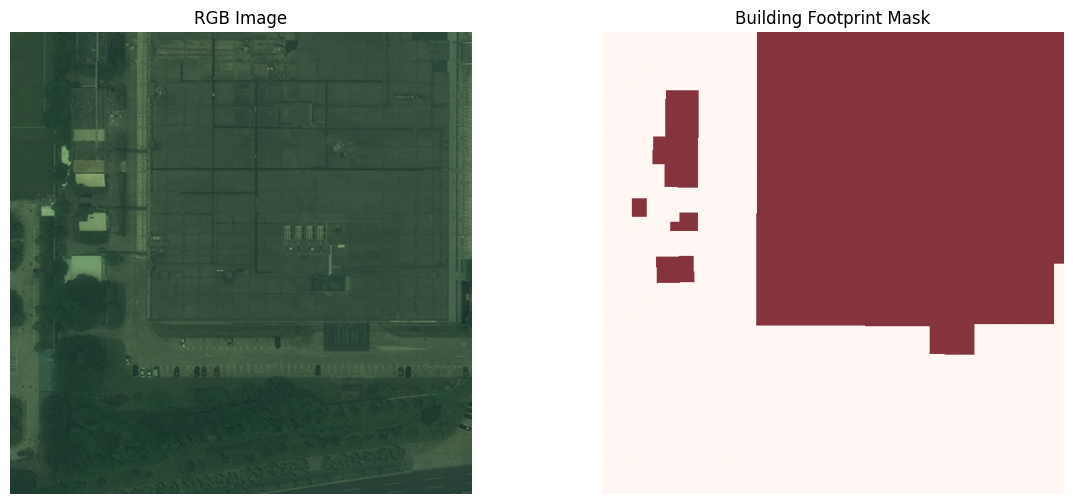

In [49]:
# Test Rasterization Code for Dataset


# ----- Paths (using ../) -----
tile_id = "img1010"

img_path = f"../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_{tile_id}.tif"
geojson_path = f"../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_{tile_id}.geojson"

# ----- Load image -----
with rasterio.open(img_path) as src:
    rgb = src.read()  # (3, H, W)
    transform = src.transform
    height, width = rgb.shape[1], rgb.shape[2]

print("Image shape:", rgb.shape)

# ----- Load GeoJSON -----
gdf = gpd.read_file(geojson_path)

# remove Z component (POLYGON Z → POLYGON)
gdf["geometry"] = gdf["geometry"].apply(lambda geom: 
                                        type(geom)([(x,y) for x,y,z in geom.exterior.coords])
                                        if geom.geom_type == "Polygon" else geom)

# ----- Rasterize -----
mask = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)

print("Mask shape:", mask.shape)

# ----- Normalize image for display -----
rgb_norm = np.transpose(rgb.astype(float), (1,2,0))
rgb_norm = (rgb_norm - rgb_norm.min()) / (rgb_norm.max() - rgb_norm.min())

# ----- Plot -----
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_norm)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="Reds", alpha=0.8)
plt.title("Building Footprint Mask")
plt.axis("off")

plt.show()

DINOv2 model loaded successfully.
tokens shape: torch.Size([1, 1370, 768])


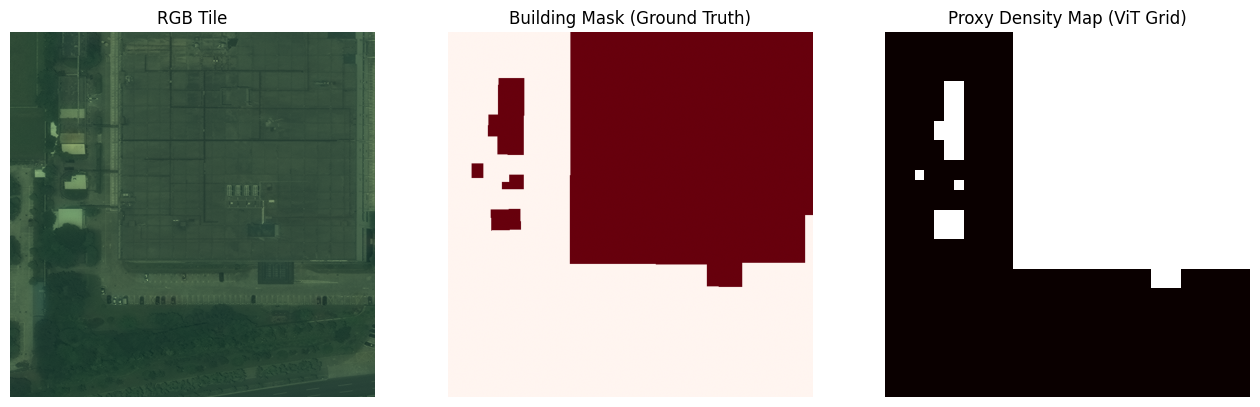

===== EcoVision-Lite Tile Summary =====
Tile ID: img1010
Buildings (count): 5
Total footprint area (m²): 31313.179427572584
Mean footprint area (m²): 6262.635885514517
--- Proxy Metrics ---
Proxy index (mean): 0.44631118
Proxy sum: 611.0
Proxy non-zero cells: 611
--- Correlation ---
Correlation between GT and Proxy: 0.9999999999999999


In [3]:
# Visualize Sample Shanghai Data


device = "cuda" if torch.cuda.is_available() else "cpu"


# 1. LOAD DINOv2 MODEL

dinov2_model = timm.create_model(
    "vit_base_patch14_dinov2.lvd142m",
    pretrained=True
)
dinov2_model.eval()
dinov2_model.to(device)

print("DINOv2 model loaded successfully.")


# 2. PIPELINE FOR ONE TILE

tile_id = "img1010"

img_path = f"../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_{tile_id}.tif"
geo_path = f"../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_{tile_id}.geojson"


# 2.1 LOAD RGB IMAGE

with rasterio.open(img_path) as src:
    rgb = src.read()                     # (3, H, W)
    height, width = rgb.shape[1], rgb.shape[2]
    transform = src.transform

# Normalize for display
rgb_norm = rgb.astype(float)
rgb_norm = (rgb_norm - rgb_norm.min()) / (rgb_norm.max() - rgb_norm.min())
rgb_norm = np.transpose(rgb_norm, (1,2,0))


# 2.2 LOAD & CLEAN POLYGONS

gdf = gpd.read_file(geo_path)

# Remove Z component
def strip_z(geom):
    if geom.geom_type == "Polygon":
        return Polygon([(x, y) for x, y, *_ in geom.exterior.coords])
    return geom

gdf["geometry"] = gdf["geometry"].apply(strip_z)


# 2.3 PROJECT POLYGONS TO UTM (ACCURATE AREA)

# WKT UTM zone for Las Vegas area = UTM Zone 11N (EPSG 32611)
gdf_utm = gdf.to_crs(epsg=32611)

# Compute accurate areas
gdf_utm["area_m"] = gdf_utm.geometry.area

building_count = len(gdf_utm)
total_area = gdf_utm["area_m"].sum()
mean_area = gdf_utm["area_m"].mean()


# 2.4 RASTERIZE POLYGONS (GT MASK)

mask = rfeat.rasterize(
    [(geom, 1) for geom in gdf["geometry"]],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)


# 2.5 PREPARE IMAGE FOR ViT-DINOv2

pil = Image.fromarray((rgb_norm * 255).astype(np.uint8))

preproc = T.Compose([
    T.Resize((518, 518)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])

x = preproc(pil).unsqueeze(0).to(device)


# 2.6 EXTRACT PATCH TOKENS (tokens.shape = 1×1370×768)

with torch.no_grad():
    tokens = dinov2_model.forward_features(x)
    
print("tokens shape:", tokens.shape)

# GRID SIZE: 1370 patches = 1 CLS + 1369 spatial
num_tokens = tokens.shape[1]
grid = int(np.sqrt(num_tokens - 1))   # 1369 → 37

# Remove CLS token for spatial grid
tokens_spatial = tokens[:, 1:, :]     # shape = (1, 1369, 768)

# Reshape → grid (1, 37, 37, 768)
feat_grid = tokens_spatial.reshape(1, grid, grid, -1).permute(0, 3, 1, 2)
# shape (1, 768, 37, 37)


# 2.7 DOWNSAMPLE MASK TO 37×37

mask_tensor = torch.tensor(mask).float().unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
mask_ds = F.interpolate(mask_tensor, size=(grid, grid), mode="nearest")
mask_ds_np = mask_ds.squeeze().cpu().numpy()


# 2.8 PROXY METRICS

proxy_index = mask_ds_np.mean()
proxy_sum = mask_ds_np.sum()
proxy_nonzero = (mask_ds_np > 0).sum()


# 2.9 SIMPLE CORRELATION (quick check)

corr = np.corrcoef(
    np.array([building_count, total_area]),
    np.array([proxy_index, proxy_sum])
)[0, 1]


# 3. VISUALIZATION

plt.figure(figsize=(16, 5))

plt.subplot(1,3,1)
plt.imshow(rgb_norm)
plt.title("RGB Tile")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="Reds")
plt.title("Building Mask (Ground Truth)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(mask_ds_np, cmap="hot")
plt.title("Proxy Density Map (ViT Grid)")
plt.axis("off")

plt.show()


# 4. PRINT SUMMARY

print("===== EcoVision-Lite Tile Summary =====")
print("Tile ID:", tile_id)
print("Buildings (count):", building_count)
print("Total footprint area (m²):", total_area)
print("Mean footprint area (m²):", mean_area)
print("--- Proxy Metrics ---")
print("Proxy index (mean):", proxy_index)
print("Proxy sum:", proxy_sum)
print("Proxy non-zero cells:", proxy_nonzero)
print("--- Correlation ---")
print("Correlation between GT and Proxy:", corr)

In [50]:
# Shanghai full building-metrics and bbox extraction


# CONFIG
SPACENET_BASE = "../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train"   # change if needed
PS_RGB_DIR = os.path.join(SPACENET_BASE, "RGB-PanSharpen")
GEOJSON_DIR = os.path.join(SPACENET_BASE, "geojson", "buildings")

OUTPUT_DIR = "../data/output/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUT_CSV = os.path.join(OUTPUT_DIR, "shanghai_all_tile_metrics.csv")
SKIPPED_CSV = os.path.join(OUTPUT_DIR, "shanghai_skipped_tiles.csv")

# UTM zone for Shanghai (approx lon ~121.6) -> UTM zone 51N -> EPSG:32651
PROJECTED_EPSG = 32651
WGS84_EPSG = 4326

# Helper
def get_tile_id_from_filename(fn):
    # tries to extract tile numeric id if pattern includes 'imgXXXX'
    base = os.path.basename(fn)
    # common SpaceNet pattern contains 'img{number}' e.g. '..._img2201.tif'
    m = re.search(r"img(\d+)", base)
    if m:
        return int(m.group(1))
    return base

# Find tiles
# Support patterns: SN2_buildings_train_AOI_4_Shanghai_PS-RGB_imgXXXX.tif
search_pattern = os.path.join(PS_RGB_DIR, "*.tif")
tile_files = sorted(glob.glob(search_pattern))
print(f"Found {len(tile_files)} PS-RGB tiles (pattern: {search_pattern})")

# Process each tile
rows = []
skipped = []

for tile_fp in tqdm(tile_files, desc="Tiles"):
    try:
        tile_id = get_tile_id_from_filename(tile_fp)
        # Read tile bounds (rasterio)
        try:
            with rasterio.open(tile_fp) as src:
                tile_bounds = src.bounds
                tile_crs = src.crs
        except Exception as e:
            skipped.append({"tile_file": tile_fp, "reason": f"rasterio_read_error: {e}"})
            continue

        # Build expected geojson filename (two common patterns: with and without full prefix)
        # Try several candidate names:
        candidates = []
        # pattern 1: same base name but prefix 'buildings_..._{tile}.geojson' - try both
        base_name = os.path.basename(tile_fp).replace(".tif","")
        candidates.append(os.path.join(GEOJSON_DIR, f"buildings_AOI_4_Shanghai_{base_name}.geojson"))
        # pattern 2: tile numeric id only
        if isinstance(tile_id, int):
            candidates.append(os.path.join(GEOJSON_DIR, f"buildings_AOI_4_Shanghai_img{tile_id}.geojson"))
            candidates.append(os.path.join(GEOJSON_DIR, f"buildings_AOI_4_Shanghai_{tile_id}.geojson"))
        # pattern 3: maybe files are lower/upper
        candidates.append(os.path.join(GEOJSON_DIR, base_name + ".geojson"))

        geojson_fp = None
        for c in candidates:
            if os.path.exists(c):
                geojson_fp = c
                break

        # If no geojson found, skip (tile bbox still recorded)
        if geojson_fp is None:
            skipped.append({"tile_file": tile_fp, "reason": "no_geojson_found", "candidates_checked": candidates})
            # still record a row with zero building metrics so later steps can use bbox
            # tile_bounds is rasterio.coords.BoundingBox(left, bottom, right, top)
            rows.append({
                "tile_file": tile_fp,
                "tile_id": tile_id,
                "building_count": 0,
                "building_total_area_m2": 0.0,
                "building_mean_area_m2": 0.0,
                "minx": tile_bounds.left,
                "miny": tile_bounds.bottom,
                "maxx": tile_bounds.right,
                "maxy": tile_bounds.top,
                "tile_crs": tile_crs.to_string() if tile_crs else None,
                "geojson_file": None
            })
            continue

        # Read geojson
        try:
            g = gpd.read_file(geojson_fp)
        except Exception as e:
            skipped.append({"tile_file": tile_fp, "reason": f"geojson_read_error: {e}", "geojson": geojson_fp})
            continue

        # If GeoDataFrame empty, treat as no buildings (still save)
        if g is None or len(g) == 0:
            rows.append({
                "tile_file": tile_fp,
                "tile_id": tile_id,
                "building_count": 0,
                "building_total_area_m2": 0.0,
                "building_mean_area_m2": 0.0,
                "minx": tile_bounds.left,
                "miny": tile_bounds.bottom,
                "maxx": tile_bounds.right,
                "maxy": tile_bounds.top,
                "tile_crs": tile_crs.to_string() if tile_crs else None,
                "geojson_file": geojson_fp
            })
            continue

        # Reproject to projected CRS (for accurate area in m^2)
        try:
            g_proj = g.to_crs(epsg=PROJECTED_EPSG)
        except Exception as e:
            # fallback: try to set original crs then reproject
            if g.crs is None:
                g = g.set_crs(epsg=WGS84_EPSG, allow_override=True)
            g_proj = g.to_crs(epsg=PROJECTED_EPSG)

        # compute area in m2
        g_proj["area_m2"] = g_proj.geometry.area

        building_count = int(len(g_proj))
        total_area = float(g_proj["area_m2"].sum())
        mean_area = float(g_proj["area_m2"].mean()) if building_count > 0 else 0.0

        # To be robust, convert tile bounds to WGS84 using rasterio transform
        # Assume tile bounds are already in WGS84; if not — note tile_crs.

        rows.append({
            "tile_file": tile_fp,
            "tile_id": tile_id,
            "building_count": building_count,
            "building_total_area_m2": total_area,
            "building_mean_area_m2": mean_area,
            "minx": tile_bounds.left,
            "miny": tile_bounds.bottom,
            "maxx": tile_bounds.right,
            "maxy": tile_bounds.top,
            "tile_crs": tile_crs.to_string() if tile_crs else None,
            "geojson_file": geojson_fp
        })

    except Exception as exc:
        skipped.append({"tile_file": tile_fp, "reason": f"unknown_error: {exc}"})
        continue

# Save outputs
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)

df_skipped = pd.DataFrame(skipped)
df_skipped.to_csv(SKIPPED_CSV, index=False)

print("DONE.")
print("Saved metrics:", OUT_CSV)
print("Saved skipped list:", SKIPPED_CSV)
print("Processed tiles:", len(df))
print("Skipped entries:", len(df_skipped))

Found 4582 PS-RGB tiles (pattern: ../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/*.tif)


Tiles: 100%|███████████████████████████████| 4582/4582 [00:08<00:00, 535.62it/s]

DONE.
Saved metrics: ../data/output/shanghai_all_tile_metrics.csv
Saved skipped list: ../data/output/shanghai_skipped_tiles.csv
Processed tiles: 4582
Skipped entries: 0


In [52]:
# reprojection of night_lights/viirs_global_utm51.tif


# INPUT / OUTPUT PATHS 
VIIRS_WGS84 = "../data/night_lights/VNL_v21_npp_2020_global_vcmslcfg_c202205302300.average_masked.dat.tif"
VIIRS_UTM51 = "../data/night_lights/viirs_global_utm51.tif"

# TARGET CRS — UTM Zone 51N (Shanghai zone)
TARGET_CRS = "EPSG:32651"

# OPEN GLOBAL VIIRS
with rasterio.open(VIIRS_WGS84) as src:
    print("Source CRS:", src.crs)
    print("Source bounds:", src.bounds)
    print("Source size:", src.width, src.height)
    
    # COMPUTE TRANSFORM & OUTPUT SHAPE
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src.crs, TARGET_CRS, src.width, src.height, *src.bounds
    )

    dst_profile = src.profile.copy()
    dst_profile.update({
        "crs": TARGET_CRS,
        "transform": dst_transform,
        "width": dst_width,
        "height": dst_height
    })

    # WRITE THE REPROJECTED GLOBAL FILE
    with rasterio.open(VIIRS_UTM51, "w", **dst_profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.bilinear
        )

print("DONE — Reprojected VIIRS (Shanghai) saved to:", VIIRS_UTM51)

Source CRS: EPSG:4326
Source bounds: BoundingBox(left=-180.00208333335, bottom=-65.00208445335001, right=180.00208621335, top=75.00208333335)
Source size: 86401 33601
DONE — Reprojected VIIRS (Shanghai) saved to: ../data/night_lights/viirs_global_utm51.tif


In [54]:
# Night-Lights Extraction (M3-optimized)


# CONFIG
INPUT_CSV = "../data/output/shanghai_all_tile_metrics.csv"
VIIRS_UTM51 = "../data/night_lights/viirs_global_utm51.tif"
OUTPUT_CSV = "../data/output/shanghai_with_lights.csv"

# Shanghai coordinate systems
WGS84 = "EPSG:4326"
UTM51 = "EPSG:32651"

# LOAD TILE METRICS
df = pd.read_csv(INPUT_CSV)
print("Tiles loaded:", len(df))

# PREPARE COORDINATE TRANSFORMER (WGS84 → UTM51)
transformer = Transformer.from_crs(WGS84, UTM51, always_xy=True)

# OPEN VIIRS (already in EPSG:32651)
with rasterio.open(VIIRS_UTM51) as src:
    print("VIIRS CRS:", src.crs)

    lights_mean = []
    lights_sum = []
    lights_nonzero = []

    for idx, row in df.iterrows():

        # 1. Convert tile bounding box → UTM51
        minx, miny = transformer.transform(row["minx"], row["miny"])
        maxx, maxy = transformer.transform(row["maxx"], row["maxy"])

        # 2. Create raster window
        try:
            window = from_bounds(minx, miny, maxx, maxy, src.transform)
            arr = src.read(1, window=window)

            if arr.size == 0:
                lights_mean.append(0)
                lights_sum.append(0)
                lights_nonzero.append(0)
                continue

            arr = arr.astype(float)
            arr[arr < 0] = 0  # remove negatives

            lights_mean.append(arr.mean())
            lights_sum.append(arr.sum())
            lights_nonzero.append(np.count_nonzero(arr))

        except Exception as e:
            print("Error on tile", row["tile_id"], ":", e)
            lights_mean.append(0)
            lights_sum.append(0)
            lights_nonzero.append(0)

# ADD LIGHT METRICS TO DATAFRAME
df["lights_mean"] = lights_mean
df["lights_sum"] = lights_sum
df["lights_nonzero"] = lights_nonzero

# SAVE OUTPUT
df.to_csv(OUTPUT_CSV, index=False)
print("DONE. Saved:", OUTPUT_CSV)

# Show sample
df.head()

Tiles loaded: 4582
VIIRS CRS: EPSG:32651
DONE. Saved: ../data/output/shanghai_with_lights.csv


,tile_file,tile_id,building_count,building_total_area_m2,building_mean_area_m2,minx,miny,maxx,maxy,tile_crs,geojson_file,lights_mean,lights_sum,lights_nonzero
0,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,1001,0,0.000000,0.000000,121.614739,31.413736,121.616494,31.415491,EPSG:4326,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,3.016680,3.016680,1
1,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,1002,0,0.000000,0.000000,121.614739,31.415491,121.616494,31.417246,EPSG:4326,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,3.055995,3.055995,1
2,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,1003,0,0.000000,0.000000,121.614739,31.417246,121.616494,31.419001,EPSG:4326,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,3.364704,3.364704,1
3,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,1005,0,0.000000,0.000000,121.614739,31.420756,121.616494,31.422511,EPSG:4326,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,5.961846,5.961846,1
4,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,1007,20,1133.535306,56.676765,121.614739,31.424266,121.616494,31.426021,EPSG:4326,../data/spacenet/AOI_4_Shanghai/AOI_4_Shanghai...,11.771608,11.771608,1


In [56]:
# Shanghai: DINOv2 ViT-B/14 (768-dim) feature extraction


# CONFIG / PATHS
INPUT_METRICS_CSV = "../data/output/shanghai_with_lights.csv"   # produced in Step 2
OUT_FEATURES_CSV   = "../data/output/shanghai_dinov2_features_768.csv"
OUT_SKIPPED_TXT    = "../data/output/shanghai_dinov2_skipped.txt"

# model / image settings
PATCH_SIZE = 14                 # ViT-B/14
OUT_DIM = 768                   # target feature dim 
MODEL_IMAGE_SIZE = 224          # typical ViT input size 
BATCH_SIZE = 8                  # per-run batch 

# PICK DEVICE (mps if available; else cpu)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# Load model
print("Loading DINOv2 ViT-B/14 model...")
model = vit_base(patch_size=PATCH_SIZE)  # this is the fallback you used earlier
model.eval()
model.to(device)
print("Loaded DINOv2 ViT-B/14 (expected dim: {}).".format(OUT_DIM))

# Preprocessing transform - Use ImageNet normalization as a sensible default for ViTs
transform = transforms.Compose([
    transforms.Resize((MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)),
    transforms.ToTensor(),  # 0..1 float32, shape C,H,W
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load list of tiles from the CSV (a 'tile_file' column is expected)
if not os.path.exists(INPUT_METRICS_CSV):
    raise FileNotFoundError(f"Input CSV not found: {INPUT_METRICS_CSV}")

df_tiles = pd.read_csv(INPUT_METRICS_CSV)
if "tile_file" not in df_tiles.columns and "tile" in df_tiles.columns:
    # accept alternate column names
    df_tiles = df_tiles.rename(columns={"tile":"tile_file"})

if "tile_file" not in df_tiles.columns:
    raise ValueError("Input CSV must contain a 'tile_file' column with full path to the RGB tile TIFFs.")

tile_rows = df_tiles["tile_file"].tolist()
print(f"Found {len(tile_rows)} tiles in CSV.")

# Extraction loop (batched)
os.makedirs(os.path.dirname(OUT_FEATURES_CSV), exist_ok=True)
skipped = []
features_out = []   # list of (tile_id, feat_vector)

def read_rgb_from_tif(path):
    # Read first 3 bands from a GeoTIFF and return an HxWx3 uint8/Numpy array suitable for PIL.
    with rasterio.open(path) as src:
        # Some files may be single band or >3 band; try to read bands 1,2,3
        if src.count < 3:
            raise ValueError("Less than 3 bands")
        arr = src.read([1,2,3])  # shape (3, H, W)
        arr = np.transpose(arr, (1,2,0))  # H,W,3
        # handle scaling: if dtype float and already 0..1, scale to 0..255
        if np.issubdtype(arr.dtype, np.floating):
            # assume 0..1 -> scale up
            arr = np.clip(arr, 0.0, 1.0)
            arr = (arr * 255).astype(np.uint8)
        else:
            # ensure uint8
            arr = arr.astype(np.uint8)
        return arr

def get_tile_id_from_path(path):
    # tries common patterns to extract the tile id (numeric)
    basename = os.path.basename(path)
    # prefer last numeric chunk in basename
    m = re.findall(r'\d+', basename)
    if m:
        return m[-1]
    return basename

start_time = time.time()
total = len(tile_rows)
i = 0

# process sequentially but in small batches (to allow model on-device)
while i < total:
    batch_paths = tile_rows[i:i+BATCH_SIZE]
    imgs = []
    ids = []
    valid_idx = []
    for j, p in enumerate(batch_paths):
        try:
            arr = read_rgb_from_tif(p)
            pil = Image.fromarray(arr)  # HxW x3
            imgs.append(transform(pil))  # C,H,W tensor
            ids.append(get_tile_id_from_path(p))
            valid_idx.append(j)
        except Exception as e:
            skipped.append((p, str(e)))
            print(f"Skipped tile (read error): {p}  -> {e}")

    if len(imgs) == 0:
        i += BATCH_SIZE
        continue

    # batch -> tensor
    batch = torch.stack(imgs, dim=0).to(device)  # B,C,H,W

    with torch.no_grad():
        try:
            out = model(batch)  # model output format varies by implementation
        except Exception as e:
            # if direct call fails, try forward_features or other attr
            try:
                out = model.forward_features(batch)
            except Exception as e2:
                print("Model forward failed:", e, e2)
                # mark all as skipped
                for p in batch_paths:
                    skipped.append((p, "model_forward_failed"))
                i += BATCH_SIZE
                continue

        # Try to extract a single global vector per sample from 'out'
        # 'out' can be tensor (B, N, D) or dict or tuple; handle common cases.
        if isinstance(out, torch.Tensor):
            tensor_out = out
        elif isinstance(out, (tuple, list)):
            # prefer first element
            tensor_out = out[0]
        elif isinstance(out, dict):
            # try several common keys
            candidate = None
            for k in ("pooled", "embedding", "global", "last_hidden_state", "x"):
                if k in out:
                    candidate = out[k]
                    break
            if candidate is None:
                # take first value
                candidate = list(out.values())[0]
            tensor_out = candidate
        else:
            # unknown type
            raise RuntimeError("Unrecognized model output type: {}".format(type(out)))

        # tensor_out typically has shape (B, N, D) or (B, D)
        if tensor_out.dim() == 3:
            # (B, Ntokens, D) — pool tokens to get global vector
            # exclude class token if number of tokens > 1 and there's a [CLS]
            # safest: mean over token dim
            feat = tensor_out.mean(dim=1)   # (B, D)
        elif tensor_out.dim() == 2:
            feat = tensor_out               # (B, D)
        else:
            raise RuntimeError("Unexpected tensor_out shape: {}".format(tensor_out.shape))

        # move to cpu & convert to numpy
        feat_np = feat.cpu().numpy()  # (B, D)
        # if D != OUT_DIM, still keep whatever dimension is returned (we'll write columns accordingly)
        D = feat_np.shape[1]

        # Append to features_out aligned with ids
        for k_idx, global_vec in enumerate(feat_np):
            tile_id = ids[k_idx]
            features_out.append((tile_id, global_vec.copy()))

    i += BATCH_SIZE

elapsed = time.time() - start_time
print(f"Extraction finished in {elapsed:.1f}s. Processed: {len(features_out)} features. Skipped: {len(skipped)}")

# WRITE FEATURES CSV
if len(features_out) == 0:
    print("No features extracted — aborting save.")
else:
    # determine D
    D = features_out[0][1].shape[0]
    header = ["tile_id"] + [f"f{i+1}" for i in range(D)]
    with open(OUT_FEATURES_CSV, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for tile_id, vec in features_out:
            row = [tile_id] + [float(x) for x in vec.tolist()]
            writer.writerow(row)
    print("Saved features CSV ->", OUT_FEATURES_CSV)

# WRITE skipped list
if skipped:
    with open(OUT_SKIPPED_TXT, "w") as f:
        for p, reason in skipped:
            f.write(f"{p}\t{reason}\n")
    print("Saved skipped list ->", OUT_SKIPPED_TXT)
else:
    print("No skipped tiles.")


Using device: mps
Loading DINOv2 ViT-B/14 model...
Loaded DINOv2 ViT-B/14 (expected dim: 768).
Found 4582 tiles in CSV.
Extraction finished in 70.1s. Processed: 4582 features. Skipped: 0
Saved features CSV -> ../data/output/shanghai_dinov2_features_768.csv
No skipped tiles.


In [59]:
# Step 4 - Merge features lights and building metrics


# CONFIG / PATHS
METRICS_CSV = "../data/output/shanghai_with_lights.csv"
DINO_CSV    = "../data/output/shanghai_dinov2_features_768.csv"
OUTPUT_CSV  = "../data/output/shanghai_merged_full.csv"

# Load datasets
df_metrics = pd.read_csv(METRICS_CSV)
df_dino = pd.read_csv(DINO_CSV)

print("Metrics columns:", df_metrics.columns.tolist())
print("DINO columns:", df_dino.columns.tolist())

# Ensure tile_id is integer in both
df_metrics["tile_id"] = df_metrics["tile_id"].astype(int)
df_dino["tile_id"] = df_dino["tile_id"].astype(int)

# Merge on tile_id
df_merged = df_metrics.merge(df_dino, on="tile_id", how="inner")

print("Merged shape:", df_merged.shape)

# Save
df_merged.to_csv(OUTPUT_CSV, index=False)
print("Saved merged dataset →", OUTPUT_CSV)

Metrics columns: ['tile_file', 'tile_id', 'building_count', 'building_total_area_m2', 'building_mean_area_m2', 'minx', 'miny', 'maxx', 'maxy', 'tile_crs', 'geojson_file', 'lights_mean', 'lights_sum', 'lights_nonzero']
DINO columns: ['tile_id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 